In [1]:
# import torch
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
# from torchvision import datasets
# from torchvision import transforms
# from torchvision.transforms import ToTensor
# from torchinfo import summary

# import os
# import glob
# import time
# import datetime as dt
# from netCDF4 import Dataset as nc_Dataset
# from netCDF4 import date2num, num2date
# import pandas as pd
# import numpy as np
# import math
# import xarray as xr
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# from matplotlib.markers import MarkerStyle
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# from FunctionsAndClasses.HRRR_URMA_Datasets_AllVars import *
# from FunctionsAndClasses.DefineModelAttributes import *
# from FunctionsAndClasses.SR_UNet_simple import *
# from FunctionsAndClasses.utils import *

from FunctionsAndClasses.HEADER_FunctionsAndClasses import *
from FunctionsAndClasses.HEADER_torch import *
from FunctionsAndClasses.HEADER_utilities import *
from FunctionsAndClasses.HEADER_plotting import *

In [2]:
C = CONSTANTS()

In [3]:
## Change as needed
TARG_VAR="t2m"

In [4]:
model_1_attrs = DefineModelAttributes(is_train=False)
filename_1 = f"{C.DIR_TRAINED_MODELS}/BS24_NE50_tD_pred(t2m)_targ(t2m).pt"
model_1_attrs.set_model_attrs_from_savename(filename_1)

### Change as needed
# model_1_attrs.predictor_vars = PREDICTOR_VARS
# model_1_attrs.target_vars = TARGET_VARS

model_1_attrs.create_save_name()
model_1_attrs.create_dataset()

Making dataset for model BS24_NE50_tD_pred(t2m)_targ(t2m)
is_train = False
Terrain normalization done for ['diff']
Predictor data for t2m loaded. Time taken = 0.1 sec
Target data for t2m loaded. Time taken = 0.2 sec
DATASET CONSTRUCTION DONE


In [5]:
model_2_attrs = DefineModelAttributes(is_train=False)
filename_2 = f"{C.DIR_TRAINED_MODELS}/ATTENTION_SIMPLE_BS24_NE50_tD_pred(t2m)_targ(t2m).pt"
model_2_attrs.set_model_attrs_from_savename(filename_2)

### Change as needed
# model_2_attrs.predictor_vars = PREDICTOR_VARS
# model_2_attrs.target_vars = TARGET_VARS

model_2_attrs.create_save_name()
model_2_attrs.savename = f"ATTENTION_SIMPLE_{model_2_attrs.savename}"
model_2_attrs.create_dataset()

Making dataset for model ATTENTION_SIMPLE_BS24_NE50_tD_pred(t2m)_targ(t2m)
is_train = False
Terrain normalization done for ['diff']
Predictor data for t2m loaded. Time taken = 0.0 sec
Target data for t2m loaded. Time taken = 0.0 sec
DATASET CONSTRUCTION DONE


In [6]:
model_1 = SR_UNet_simple(n_channels_in=model_1_attrs.num_channels_in, n_channels_out=model_1_attrs.num_channels_out)
device = torch.device("cuda")
model_1.to(device)
model_1.load_state_dict(torch.load(f"{C.DIR_TRAINED_MODELS}/{model_1_attrs.savename}.pt", weights_only=True))

<All keys matched successfully>

In [7]:
# model_2 = SR_UNet_simple(n_channels_in=model_2_attrs.num_channels_in, n_channels_out=model_2_attrs.num_channels_out)
model_2 = UNet_Attention_simple(n_channels_in=model_2_attrs.num_channels_in, n_channels_out=model_2_attrs.num_channels_out)
device = torch.device("cuda")
model_2.to(device)
model_2.load_state_dict(torch.load(f"{C.DIR_TRAINED_MODELS}/{model_2_attrs.savename}.pt", weights_only=True))

<All keys matched successfully>

In [46]:
def plot_model_vs_model_error(model_1_output, model_2_output, pred, targ, date_str, error_units, avg_denom=10):
    
    maxtemp = np.max([np.max(model_1_output.squeeze()), np.max(model_2_output.squeeze()), np.max(targ.squeeze()), np.max(pred.squeeze())])
    mintemp = np.min([np.min(model_1_output.squeeze()), np.min(model_2_output.squeeze()), np.min(targ.squeeze()), np.min(pred.squeeze())])
    avg = (maxtemp-mintemp)/avg_denom
    
    fig, axs = plt.subplots(1,1, figsize=(8,8))

    # Note if model 1 and 2's output is x1, x2 respectively, and truth = y, then (x1-y)-(x2-y) = x1-y-x2+y=x1-x2
    # Thus the difference in model output is the difference in their errors
    
    pos = axs.imshow((model_1_output.squeeze() - model_2_output.squeeze()), cmap="coolwarm", origin='lower', vmin = -1*avg, vmax = avg)
    axs.axis("off")
    cbar = fig.colorbar(pos, fraction=0.03)
    cbar.set_label(f"Difference {error_units}")
    
    plt.title(f"Model 1 error minus Model 2 error, {dt_current}")

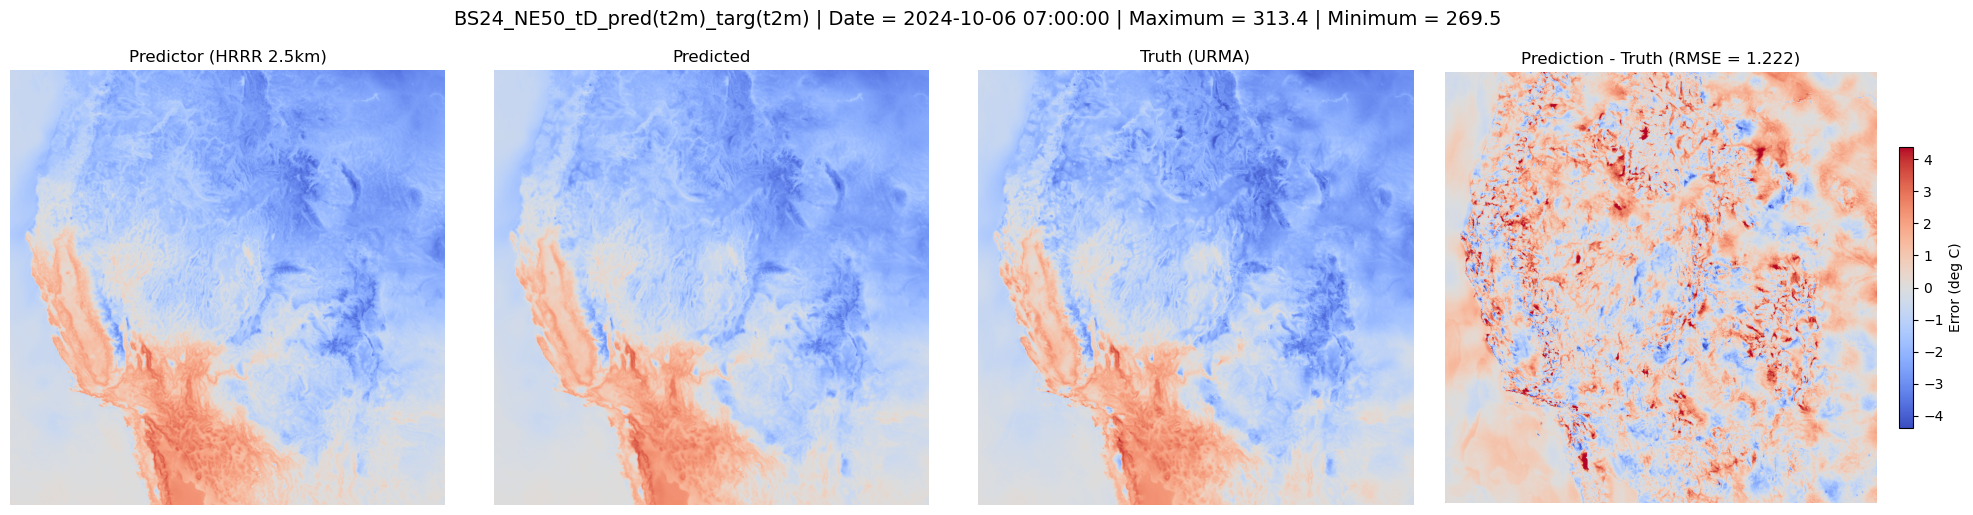

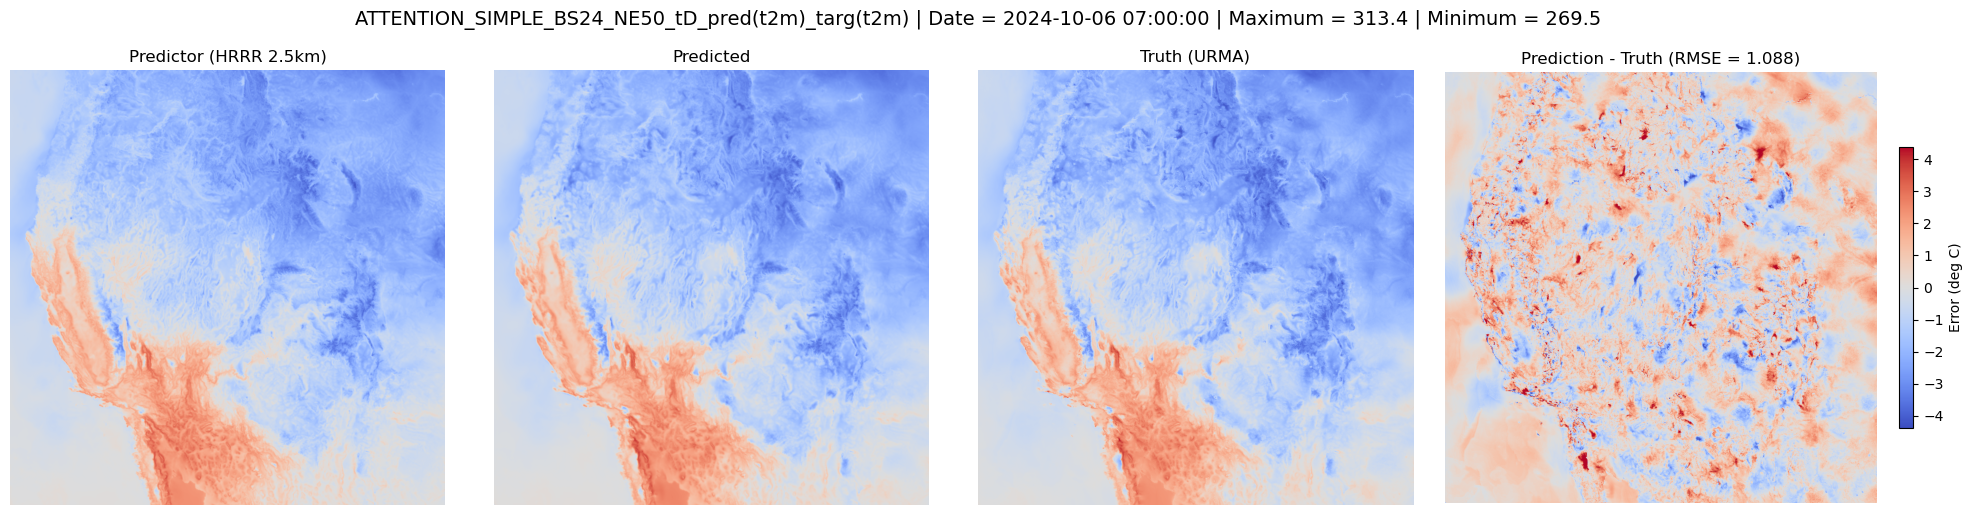

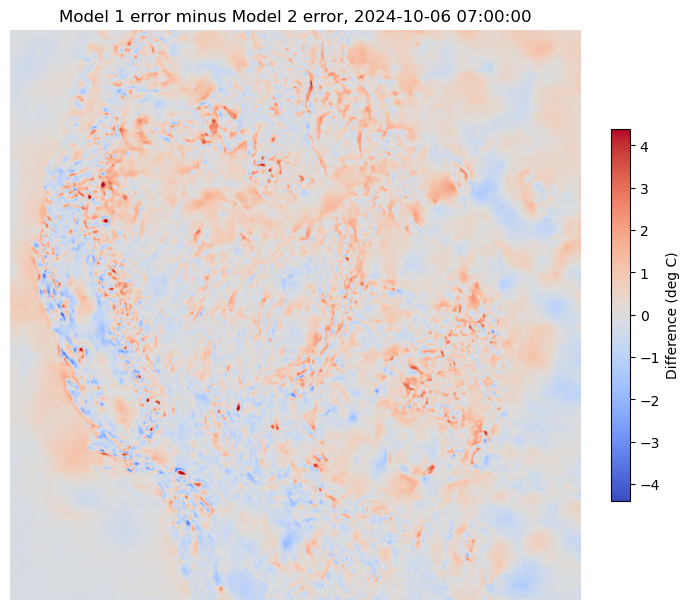

In [56]:
IDX = 6703

pred, targ, model_1_output, dt_current = get_model_output_at_idx(model_attrs=model_1_attrs, 
                                                                 model=model_1, 
                                                                 idx=IDX, 
                                                                 pred_var=TARG_VAR, 
                                                                 targ_var=TARG_VAR)

_, _, model_2_output, _ = get_model_output_at_idx(model_attrs=model_2_attrs, 
                                                  model=model_2, 
                                                  idx=IDX, 
                                                  pred_var=TARG_VAR, 
                                                  targ_var=TARG_VAR)



xr_smartinit = get_smartinit_output_at_idx(i=IDX, 
                                           FORECAST_LEAD_HOURS=1, 
                                           smartinit_directory=C.DIR_SMARTINIT_DATA,
                                           smartinit_var_select_dict=C.urma_var_select_dict, 
                                           varname_translation_dict=C.varname_translation_dict, 
                                           target_var=TARG_VAR)

if TARG_VAR=="spfh2m":
    pred = 1000*pred
    targ = 1000*targ
    model_output = 1000*model_output
    xr_smartinit = 1000*xr_smartinit
    C.varname_units_dict[TARG_VAR] = "g/kg"

if TARG_VAR=="pressurf":
    avg_denom=150
else:
    avg_denom=10


plot_predictor_output_truth_error(pred, 
                                  model_1_output, 
                                  targ, 
                                  date_str=dt_current, 
                                  title= f"{model_1_attrs.savename}", 
                                  error_units=f"({C.varname_units_dict[TARG_VAR]})", 
                                  avg_denom=avg_denom
                                 )

plot_predictor_output_truth_error(pred, 
                                  model_2_output, 
                                  targ, 
                                  date_str=dt_current, 
                                  title= f"{model_2_attrs.savename}", 
                                  error_units=f"({C.varname_units_dict[TARG_VAR]})", 
                                  avg_denom=avg_denom
                                 )

plot_model_vs_model_error(model_1_output, model_2_output, pred, targ, date_str=dt_current, error_units=f"({C.varname_units_dict[TARG_VAR]})")